# Interactive clustering APP

In [6]:
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None
import ipywidgets as widgets
from IPython.display import display

import matplotlib.pyplot as plt

## Load data

In [7]:
VaVaI_DataFrame = pd.read_csv('../code/data/TACR_Starfos_isvav_project.csv')
VaVaI_columns = VaVaI_DataFrame.columns.to_list()

## Filter columns

In [8]:
multisel_columns = widgets.SelectMultiple(
    options=VaVaI_columns,
    disabled=False,
    rows=20,
)

select_button = widgets.Button(description='Select column(s)', icon='table')

widgets.VBox([multisel_columns, select_button])

In [10]:
selected_columns = list(multisel_columns.value)
selected_columns_df = VaVaI_DataFrame[selected_columns]
selected_columns_df.head()

,Klíčová slova
0,allopregnanolone; pregnenolone; isomers of pre...
1,cystic fibrosis; newborn screening; immunoreac...
2,brain tumours; chromosomal aberration; molecul...
3,modeling; antitubercular; antifungal; cytotoxi...
4,genetic diseases; metabolism; diagnostic; mole...


## Clean the data

In [11]:
nan_rows = selected_columns_df.isna().any(axis=1)
cleaned_df = selected_columns_df[~nan_rows]

# Pair with the original df for future reference
VaVaI_DataFrame = VaVaI_DataFrame.iloc[cleaned_df.index]
cleaned_df.reset_index(inplace=True)
VaVaI_DataFrame.reset_index(inplace=True)
cleaned_df.drop(columns='index', inplace=True)
display(cleaned_df.head())

del selected_columns_df

,Klíčová slova
0,allopregnanolone; pregnenolone; isomers of pre...
1,cystic fibrosis; newborn screening; immunoreac...
2,brain tumours; chromosomal aberration; molecul...
3,modeling; antitubercular; antifungal; cytotoxi...
4,genetic diseases; metabolism; diagnostic; mole...


## Preprocess data
- concat
- convert to lowercase
- remove punctuation
- tokenize
- remove stop-words

In [21]:
import re
from string import punctuation
import nltk
from nltk.corpus import stopwords

def display_head(df):
    print('=========================================')
    for i in range(5):
        print(df[i][:100])
        print()
    
def remove_stopwords_eng(x):
    sw = stopwords.words('english')
    sw.extend(['aim', 'goal', 'attempt', 'project', 'evaluate', 'research', 'improve', 'improvement', 'development'])
    new_sentence = []
    for word in x:
        if word not in sw:
            new_sentence.append(word)
    return new_sentence

def lemmatize_text(text):
    lemmatizer = nltk.stem.WordNetLemmatizer()
    return [lemmatizer.lemmatize(w) for w in text]

def tokenize_text(text):
    tokenizer = nltk.tokenize.WhitespaceTokenizer()
    return [w for w in tokenizer.tokenize(text)]

def remove_punctuation(text):
    return re.sub(r"[{}]".format(punctuation), ' ', text)

def convert_to_lowercase(text):
    return text.lower()

transforms = {
    'Convert to lowercase': convert_to_lowercase,
    'Remove punctuation': remove_punctuation,
    'Tokenize': tokenize_text,
    'Lemmatize': lemmatize_text,
    'Remove ENG stopwords': remove_stopwords_eng,
}

multisel_transforms = widgets.SelectMultiple(
    options=transforms.keys(),
    disabled=False,
    rows=20,
)

select_button = widgets.Button(description='Select transforms(s)', icon='table')

widgets.VBox([multisel_transforms, select_button])

In [22]:
processed_data = cleaned_df.apply(' '.join, axis=1).astype(str)

for transform in multisel_transforms.value:
    processed_data = processed_data.apply(transforms[transform])
    display_head(processed_data)

allopregnanolone; pregnenolone; isomers of pregnanolone; ejaculation; orgasm; male reproduction

cystic fibrosis; newborn screening; immunoreactive trypsin; cftr gen

brain tumours; chromosomal aberration; molecular cytogenetics; i-fish; prognostic factors; instabili

modeling; antitubercular; antifungal; cytotoxicity; synthesis; lipophilicity

genetic diseases; metabolism; diagnostic; molecular basis; pathogenesis; dna microarrays; gene expre

allopregnanolone  pregnenolone  isomers of pregnanolone  ejaculation  orgasm  male reproduction

cystic fibrosis  newborn screening  immunoreactive trypsin  cftr gen

brain tumours  chromosomal aberration  molecular cytogenetics  i fish  prognostic factors  instabili

modeling  antitubercular  antifungal  cytotoxicity  synthesis  lipophilicity

genetic diseases  metabolism  diagnostic  molecular basis  pathogenesis  dna microarrays  gene expre

['allopregnanolone', 'pregnenolone', 'isomers', 'of', 'pregnanolone', 'ejaculation', 'orgasm', 'male',

## Vectorize
- TF-IDF
- Word2Vec
- Doc2Vec

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer

def vectorize_using_tf_idf(data, min_n=1, max_n=5):
    result = {}
    for i in range(min_n, max_n + 1):
        for j in range(min_n, max_n + 1):
            if i > j: continue
            print(f'Fitting TF-IDF for ngram range: ({i},{j})')
            transformer = TfidfVectorizer(ngram_range=(min_n, max_n))
            vectorized = transformer.fit_transform(data.apply(' '.join))
            result[f'tf-idf_({i},{j})'] = vectorized
    return result

In [24]:
import gensim
from gensim.models import Word2Vec
import gensim.downloader as api

model_names = ['fasttext-wiki-news-subwords-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50',
               'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 
               'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200']

def word2vec(data, model_name):
    def document_vector(sentence):
        if len(sentence) == 0:
            return np.zeros(model.vector_size)
        doc = [word for word in sentence if word in model]
        if len(doc) == 0:
            return np.zeros(model.vector_size)
        return np.mean(model[doc], axis=0)
    
    print(f'Loading model: {model_name}')
    model = api.load(model_name)
    vectorized = data.apply(document_vector)
    return np.stack(vectorized)

def vectorize_using_pretrained_word2vec(data):
    results = {}
    for model_name in model_names:
        vectorized = word2vec(data, model_name)
        results[f'word2vec_({model_name})'] = vectorized
    return results

/home/fassty/anaconda3/envs/deep_learning/lib/python3.7/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [25]:
def word2vec_train(df, vector_size):
    def document_vector(sentence):
        if len(sentence) == 0:
            return np.zeros(model.vector_size)
        doc = np.array([model.wv[word] for word in sentence])
        if len(doc) == 0:
            return np.zeros(model.vector_size)
        return np.mean(doc, axis=0)
    
    print(f'Training Word2Vec model with vector size {vector_size}')
    data = df.to_list()
    model = Word2Vec(sentences=data, vector_size=vector_size, window=5, min_count=1, workers=4)
    model.save(f'word2vec_{vector_size}')
    
    vectorized = df.apply(document_vector)
    return np.stack(vectorized)

def vectorize_using_word2vec(data):
    results = {}
    for vs in [25, 50, 100, 200]:
        vectorized = word2vec_train(data, vs)
        results[f'word2vec_{vs}'] = vectorized
    return results

In [28]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

def doc2vec_train(data, vector_size, epochs):
    print(f'Training Doc2Vec model with vector size {vector_size} for {epochs} epochs')
    model = Doc2Vec(documents=data, 
                    vector_size=vector_size, 
                    window=5, 
                    min_count=1, 
                    workers=8,
                    hs=1,
                    epochs=epochs)
    model.save(f'doc2vec_{vector_size}_{epochs}')
    return np.array([model.dv[i] for i in range(len(data))])

def vectorize_using_doc2vec(data):
    results = {}
    tagged_data = [TaggedDocument(words=sentence, tags=[index]) for sentence, index in zip(data, list(data.index))]
    for vs in [25, 50, 100, 200, 300]:
        for ep in [10, 50, 100, 200, 300]:
            vectorized = doc2vec_train(tagged_data, vs, ep)
            results[f'doc2vec_{vs}_{ep}'] = vectorized
    return results

In [29]:
models = {
    'TF-IDF': vectorize_using_tf_idf,
    'Word2Vec-Pretrained': vectorize_using_pretrained_word2vec,
    'Word2Vec': vectorize_using_word2vec,
    'Doc2Vec': vectorize_using_doc2vec
}

multisel_models = widgets.SelectMultiple(
    options=list(models.keys()),
    disabled=False,
    rows=10,
)

select_button = widgets.Button(description='Select Models', icon='table')

widgets.VBox([multisel_models, select_button])

In [30]:
import pickle

selected_models = list(multisel_models.value)
print(selected_models)
sampled_data = processed_data.sample(n=1000, random_state=42)

results = {}
for model in selected_models:
    results = {**results, **models[model](processed_data)}
    
with open('vectors.pickle', 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

['TF-IDF', 'Word2Vec-Pretrained', 'Word2Vec', 'Doc2Vec']
Fitting TF-IDF for ngram range: (1,1)
Fitting TF-IDF for ngram range: (1,2)
Fitting TF-IDF for ngram range: (1,3)
Fitting TF-IDF for ngram range: (1,4)
Fitting TF-IDF for ngram range: (1,5)
Fitting TF-IDF for ngram range: (2,2)
Fitting TF-IDF for ngram range: (2,3)
Fitting TF-IDF for ngram range: (2,4)
Fitting TF-IDF for ngram range: (2,5)
Fitting TF-IDF for ngram range: (3,3)
Fitting TF-IDF for ngram range: (3,4)
Fitting TF-IDF for ngram range: (3,5)
Fitting TF-IDF for ngram range: (4,4)
Fitting TF-IDF for ngram range: (4,5)
Fitting TF-IDF for ngram range: (5,5)
Loading model: fasttext-wiki-news-subwords-300
[==================================================] 100.0% 958.5/958.4MB downloaded
Loading model: word2vec-google-news-300
[==================================================] 100.0% 1662.8/1662.8MB downloaded
Loading model: glove-wiki-gigaword-50
[==================================================] 100.0% 66.0/66.0MB down

In [35]:
#TODO: remove this cell after testing
model = Doc2Vec.load('word2vec_200')

print(processed_data[0])
vec = model.infer_vector(processed_data[0])

similar = model.docvecs.most_similar([vec])

display(similar)

['frekvence', 'distribuce', 'inzulinorezistence', 'jako', 'rizikového', 'faktoru', 'kardiovaskulárních', 'metabolických', 'onemocněni', 'stanovení', 'jednoduchých', 'kvantitativních', 'indexů', 'homa', 'ir', 'quicki', 'u', 'skupin', 'osob', 'intolerancí', 'glukózy', 'diabetem', 'typu', '2', 'hyperlipidémií', 'obezitou', 'hypertenzí', 'kombinací', 'faktorů', 'srovnání', 'se', 'zdravými', 'jedinci', 'pro', 'posouzení', 'časného', 'stádia', 'inzulínové', 'rezistencepokus', 'stanovení', 'hraniční', 'hodnoty', 'která', 'odlišovala', 'osoby', 'rizikem', 'inzulínové', 'rezistence', 'osoby', 'bez', 'rizika', 'fb', 'endokrinologie', 'diabetologie', 'metabolismus', 'výživa', 'univerzita', 'palackého', 'v', 'olomouci', 'lékařská', 'fakulta', 'parent', 'ičo', '61989592', 'prof', 'mudr', 'vladimír', 'janout', 'csc', 'vedidk', '2512343', 'orcid', '0000', '0002', '1163', '0361', 'mz', 'ministerstvo', 'zdravotnictví']


AttributeError: 'Word2Vec' object has no attribute 'infer_vector'

## Cluster
- KMeans
- Hiearchical

In [31]:
from nltk.cluster import KMeansClusterer, euclidean_distance, cosine_distance
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

def cluster_using_kmeans(data, ax):
    model = KMeans()
    visualizer = KElbowVisualizer(model, k=(1, 40), ax=ax)
    visualizer.fit(data)

In [26]:
#with open('w2v_d2v_100/vectors.pickle', 'rb') as vec_file:
#    results = pickle.load(vec_file)
    
results['doc2vec_25_10']

array([[-0.02092326, -0.02391651, -0.03952302, ..., -0.02276623,
         0.01048272,  0.02321009],
       [-0.03242745, -0.03331917, -0.03981868, ..., -0.00822939,
         0.02165291, -0.03201029],
       [-0.0084794 , -0.00038326, -0.02655511, ..., -0.03575746,
        -0.03689454, -0.03175964],
       ...,
       [ 0.00676642, -0.02226409,  0.01929318, ..., -0.00480087,
        -0.02519187,  0.01465671],
       [ 0.02759766, -0.03788295, -0.01284873, ...,  0.01342707,
         0.03948388,  0.03552119],
       [ 0.02345872, -0.01522836,  0.0138518 , ...,  0.03875525,
        -0.00085671, -0.03549954]], dtype=float32)

In [ ]:
from pyclustertend import hopkins

def calc_hopkins_score(vector):
    if hasattr(vector, 'toarray'):
        vector = vector.toarray()
    df = pd.DataFrame(vector)
    hs = hopkins(df, vector.shape[0])
    print(f'Hopkins score for {name}: {hs:5f}')
    
for name, vector in results.items():
    if 'tf-idf' in name: continue 
    calc_hopkins_score(vector)

Finding optimal K for doc2vec_25_10...
Finding optimal K for doc2vec_25_50...
Finding optimal K for doc2vec_25_100...
Finding optimal K for doc2vec_25_200...
Finding optimal K for doc2vec_25_500...
Finding optimal K for doc2vec_50_10...
Finding optimal K for doc2vec_50_50...
Finding optimal K for doc2vec_50_100...
Finding optimal K for doc2vec_50_200...
Finding optimal K for doc2vec_50_500...
Finding optimal K for doc2vec_100_10...
Finding optimal K for doc2vec_100_50...
Finding optimal K for doc2vec_100_100...
Finding optimal K for doc2vec_100_200...
Finding optimal K for doc2vec_100_500...
Finding optimal K for doc2vec_200_10...
Finding optimal K for doc2vec_200_50...
Finding optimal K for doc2vec_200_100...
Finding optimal K for doc2vec_200_200...
Finding optimal K for doc2vec_200_500...
Finding optimal K for doc2vec_300_10...
Finding optimal K for doc2vec_300_50...
Finding optimal K for doc2vec_300_100...
Finding optimal K for doc2vec_300_200...
Finding optimal K for doc2vec_300_50

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


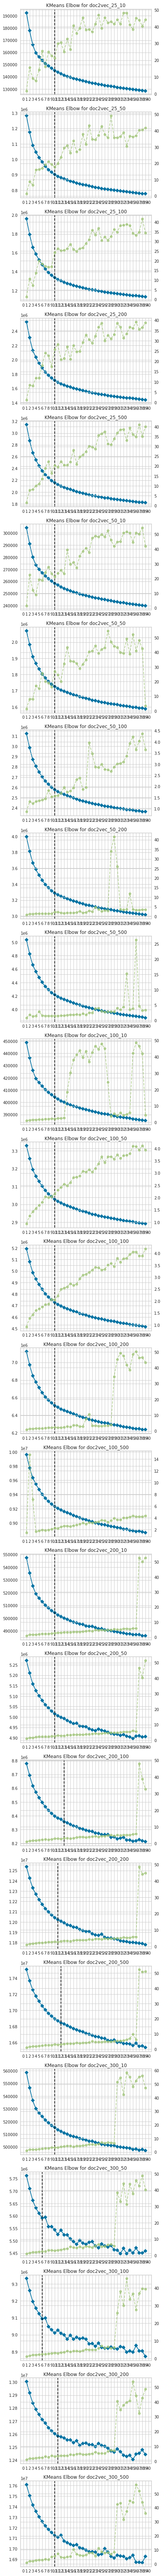

In [22]:
fig, axes = plt.subplots(len(results), figsize=(6,120))

for idx, (name, vector) in enumerate(results.items()):
    print(f'Finding optimal K for {name}...')
    cluster_using_kmeans(vector, axes[idx])
    axes[idx].set_title(f'KMeans Elbow for {name}')
    axes[idx].set_xticks(list(range(41)))
    
plt.savefig('kmeans_elbow_all_doc2vec_czech.png')
plt.show()

## Evaluate & Visualize clustering

In [84]:
multisel_models = widgets.Select(
    options=list(res.keys()),
    disabled=False,
    rows=10,
)

select_button = widgets.Button(description='Select Model', icon='table')

widgets.VBox([multisel_models, select_button])

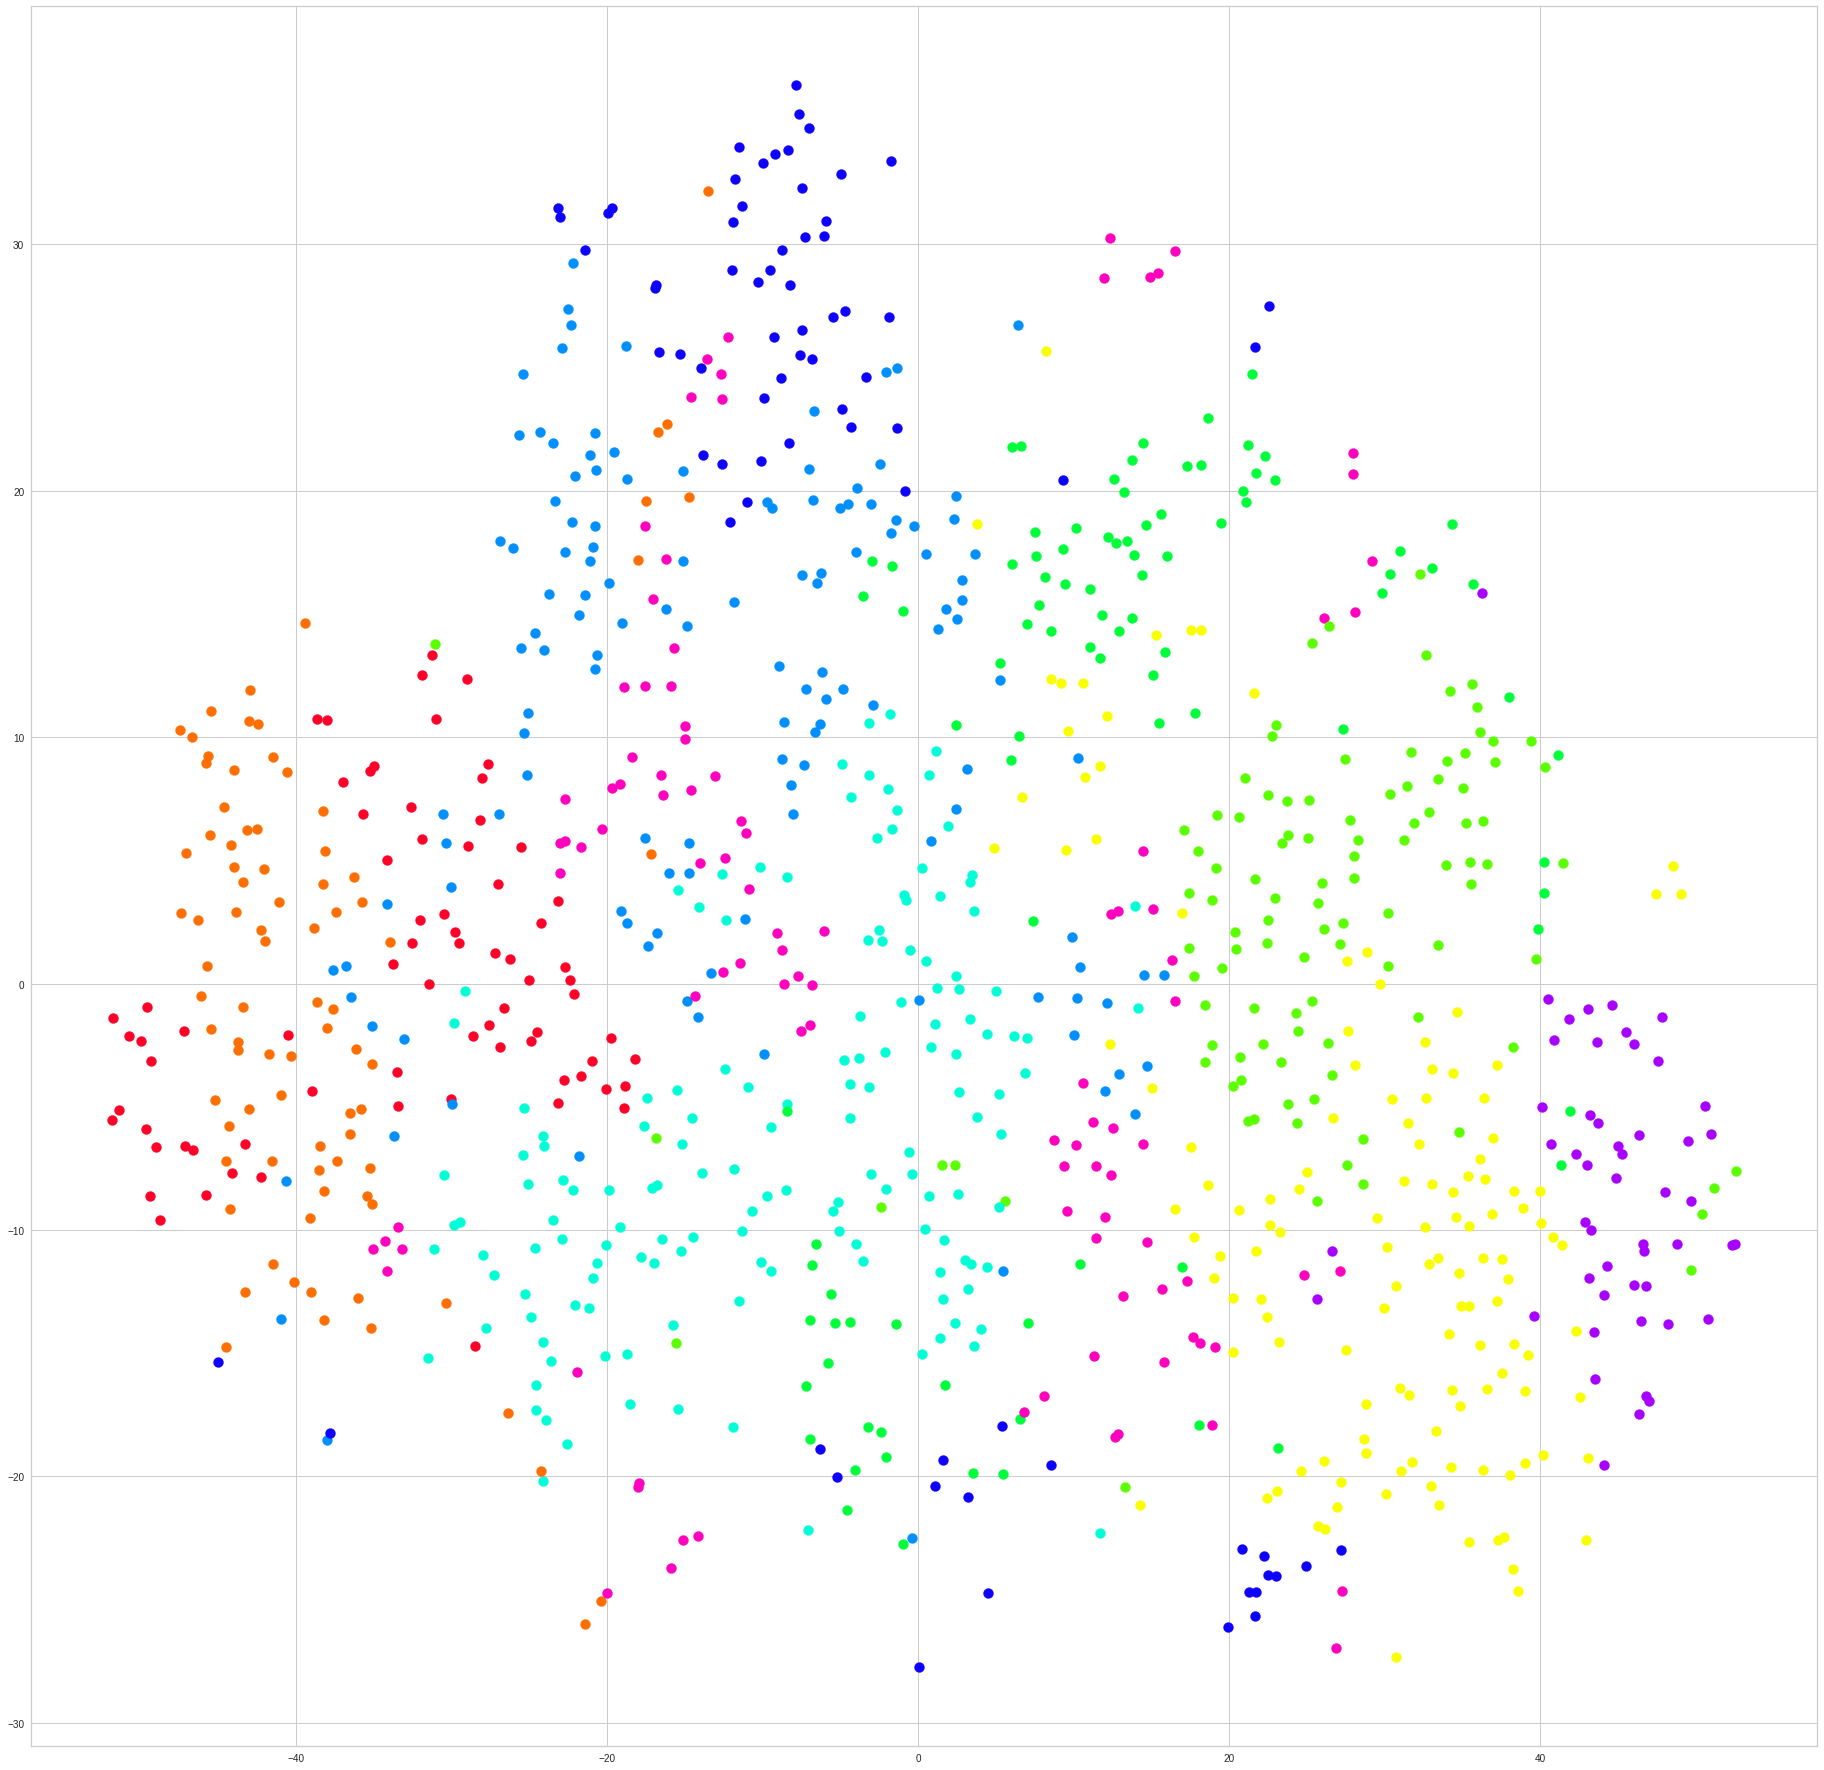

In [117]:
from sklearn.manifold import TSNE
import matplotlib.cm as cm


def visualize_clusters(vector):
    x = np.arange(10)
    ys = [i+x+(i*x)**2 for i in range(10)]
    colors = cm.gist_rainbow(np.linspace(0, 1, len(ys)))
    
    clusterer = KMeansClusterer(10, euclidean_distance)
    clustered = clusterer.cluster(vector, assign_clusters=True)
    
    tsne_model = TSNE(perplexity=30, n_components=2, init='pca', n_iter=25000, random_state=23, n_jobs=-1)
    tsne_clusters = tsne_model.fit_transform(vector)
    
    x = []
    y = []
    for value in tsne_clusters:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(32, 32)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i], color=colors[clustered[i]], s=100)
    
visualize_clusters(res[multisel_models.value])

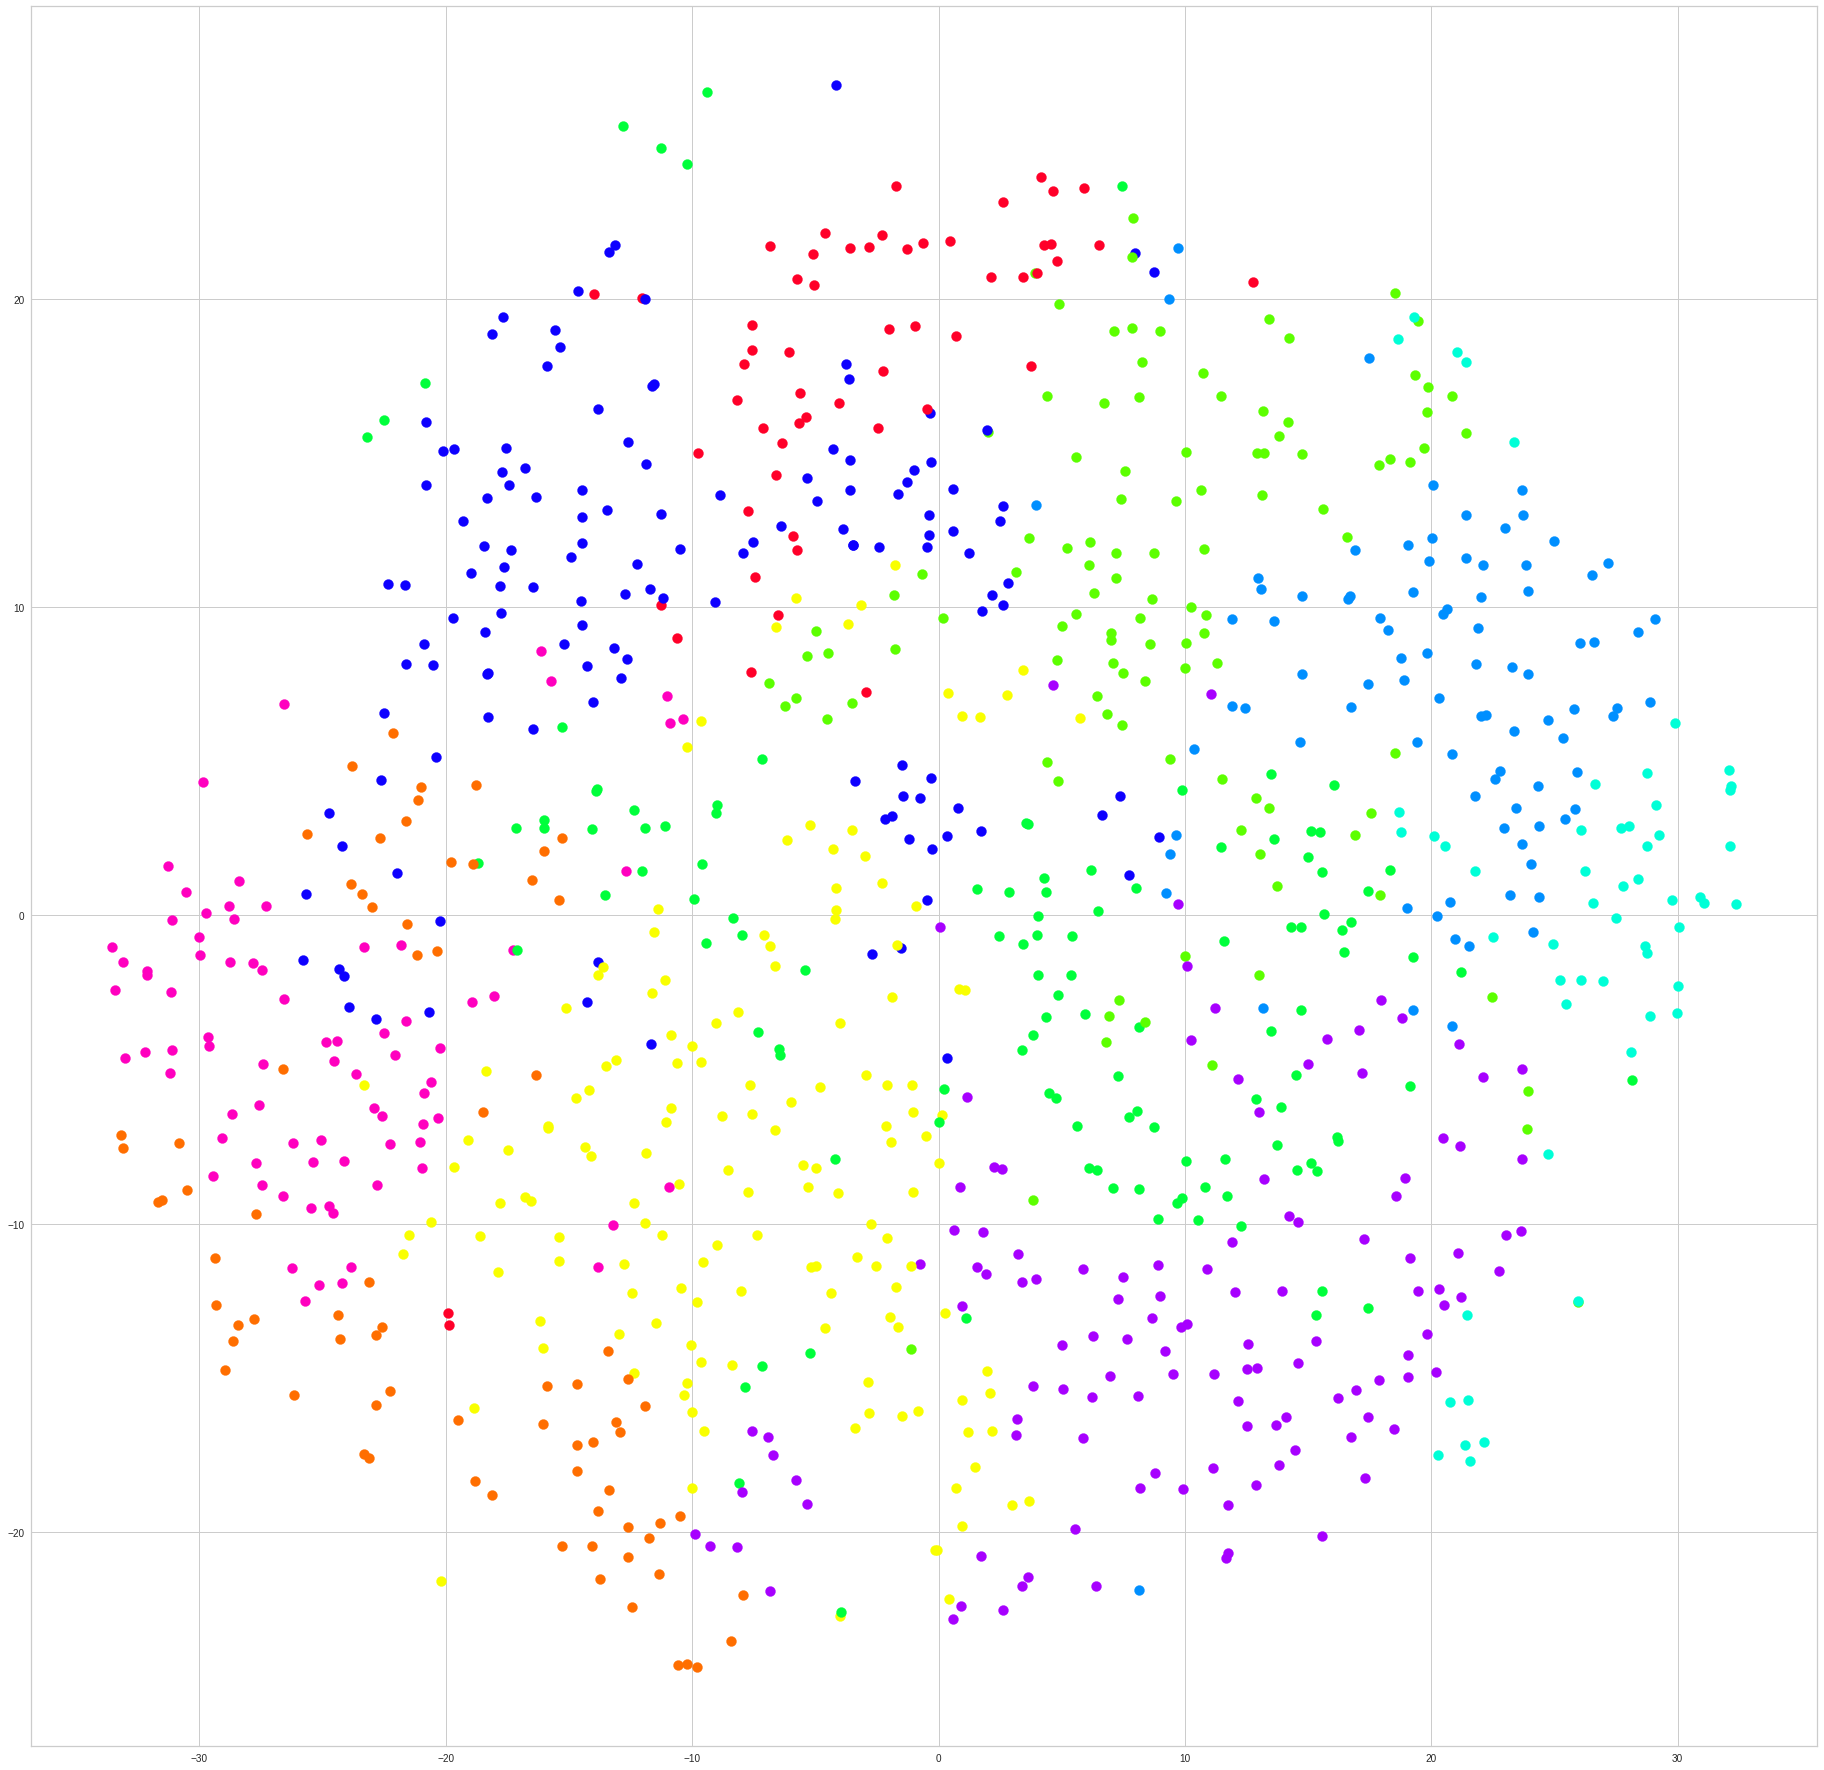

In [115]:
visualize_clusters(res[multisel_models.value])

In [125]:
hopkins(pd.DataFrame(res[multisel_models.value]), res[multisel_models.value].shape[0])

0.1807210840577872

In [123]:
multisel_models.value

'word2vec_(fasttext-wiki-news-subwords-300)'

['u',
 's',
 'i',
 'n',
 'g',
 ' ',
 'd',
 'n',
 'a',
 ' ',
 'g',
 'e',
 'n',
 'e',
 'r',
 'a',
 't',
 'e',
 ' ',
 'l',
 'i',
 'g',
 'h',
 't',
 ' ',
 'v',
 'i',
 't',
 'r',
 'o',
 ' ',
 's',
 'e',
 'l',
 'e',
 'c',
 't',
 'i',
 'o',
 'n',
 ' ',
 'h',
 'a',
 ' ',
 'u',
 's',
 'e',
 'd',
 ' ',
 'g',
 'e',
 'n',
 'e',
 'r',
 'a',
 't',
 'e',
 ' ',
 'w',
 'i',
 'd',
 'e',
 ' ',
 'v',
 'a',
 'r',
 'i',
 'e',
 't',
 'y',
 ' ',
 'n',
 'u',
 'c',
 'l',
 'e',
 'i',
 'c',
 ' ',
 'a',
 'c',
 'i',
 'd',
 ' ',
 'm',
 'o',
 't',
 'i',
 'f',
 ' ',
 'p',
 'o',
 't',
 'e',
 'n',
 't',
 'i',
 'a',
 'l',
 ' ',
 'f',
 'a',
 'c',
 'i',
 'l',
 'i',
 't',
 'a',
 't',
 'e',
 ' ',
 'b',
 'a',
 's',
 'i',
 'c',
 ' ',
 'c',
 'o',
 'm',
 'p',
 'l',
 'e',
 'm',
 'e',
 'n',
 't',
 ' ',
 'g',
 'r',
 'o',
 'w',
 'i',
 'n',
 'g',
 ' ',
 't',
 'o',
 'o',
 'l',
 'k',
 'i',
 't',
 ' ',
 'f',
 'u',
 'n',
 'c',
 't',
 'i',
 'o',
 'n',
 'a',
 'l',
 ' ',
 'e',
 'l',
 'e',
 'm',
 'e',
 'n',
 't',
 ' ',
 'd',
 'e',
 's',
 'c'